In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install patchify

In [3]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.utils import to_categorical, normalize
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.metrics import MeanIoU
import datetime

In [4]:
# Set random seed
tf.random.set_seed(42)

In [5]:
# Define Dice metric function
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Define Dice loss function (renamed to avoid naming collision)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Ensure that the predicted values are non-zero to prevent log(0) errors
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute Focal Loss
    focal_loss = tf.keras.losses.categorical_focal_crossentropy(y_true,
                                                                y_pred,
                                                                alpha=alpha,
                                                                gamma=gamma,
                                                                from_logits=False,
                                                                label_smoothing=0.0,
                                                                axis=-1)

    return focal_loss


def hybrid_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Ensure that the predicted values are non-zero to prevent log(0) errors
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute Focal Loss
    focal_loss_func = focal_loss(y_true, y_pred, alpha=alpha, gamma=gamma)

    # Compute Dice Loss
    dice_loss_func = dice_loss(y_true, y_pred)

    # Compute hybrid loss as a combination of Focal Loss and Dice Loss
    loss = 0.5 * focal_loss_func + 0.5 * dice_loss_func

    return loss

In [6]:
# Define Model
def multi_unet_model(img_width, img_height, img_channels, n_classes=3):
    inputs = Input((img_width, img_height, img_channels))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coefficient])
    # model.summary()

    return model

In [7]:
# Directories
base_dir = '/content/drive/MyDrive/TCC_FACENS'
image_directory = base_dir + '/dataset/i_dataset'
mask_directory = base_dir + '/dataset/m_improved'

In [8]:
# # Read Image files
# images = os.listdir(image_directory)
# sorted_images = sorted(images)

# image_dataset = []
# for i, image_name in enumerate(sorted_images):
#     if image_name.lower().endswith(('.tif')):
#         image_path = os.path.join(image_directory, image_name)
#         try:
#             image = Image.open(image_path)
#             image = image.convert('L')
#             image_array = np.array(image)
#             image_dataset.append(image_array)
#         except Exception as e:
#             print(f"Error reading image {image_path}: {e}")


# # Read Mask files
# masks = os.listdir(mask_directory)
# sorted_masks = sorted(masks)

# mask_dataset = []
# for i, mask_name in enumerate(sorted_masks):
#     if mask_name.lower().endswith(('.tif')):
#         mask_path = os.path.join(mask_directory, mask_name)
#         try:
#             mask = Image.open(mask_path)
#             mask_array = np.array(mask)
#             mask_dataset.append(mask_array)
#         except Exception as e:
#             print(f"Error reading image {mask_path}: {e}")

# #Normalize images
# image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),axis=3)

# #Do not normalize masks, just rescale to 0 to 1.
# mask_dataset = np.expand_dims((np.array(mask_dataset)), 3)

# # Save image and mask datasets
# np.save( base_dir + '/notebooks/dataset_input/image_dataset.npy', image_dataset)
# np.save( base_dir + '/notebooks/dataset_input/mask_dataset.npy', mask_dataset)

In [9]:
# Load image and mask datasets
image_dataset = np.load( base_dir + '/notebooks/dataset_input/image_dataset.npy')
mask_dataset = np.load( base_dir + '/notebooks/dataset_input/mask_dataset.npy')

In [10]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(image_dataset,
                                                    mask_dataset,
                                                    test_size = 0.2,
                                                    random_state = 42)

# Changing mask dataset to categorical
y_train_cat = to_categorical(y_train, num_classes= 3)
y_test_cat = to_categorical(y_test, num_classes= 3)

In [11]:
# # Rebalancing dataset
# class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes= np.unique(mask_dataset), y= mask_dataset.flatten())
# class_weights_dict = dict(zip(np.unique(mask_dataset), class_weights))
# print(class_weights_dict)

class_weights_dict = {0: 6.5194515623338445, 1: 0.4381585066727102, 2: 1.7720009924840554}

In [12]:
# Define Model
model = multi_unet_model(256, 256, 1, 3)

In [13]:
# Training Parameters
batch_input = 30
epoch_input = 50

# Definindo o Early Stopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10, verbose=1,
                           restore_best_weights=True)

# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    total_iterations = len(X_train) // batch_input * epoch_input
    return lr * (1 - epoch / epoch_input) ** 0.9

# Create the LearningRateScheduler callback
lr_ajust = LearningRateScheduler(lr_schedule)

In [14]:
start2 = datetime.datetime.now()

# Train the model
history = model.fit(X_train, y_train_cat,
                    batch_size = batch_input,
                    verbose=1,
                    epochs= epoch_input,
                    validation_data= (X_test, y_test_cat),
                    class_weight= class_weights_dict,
                    shuffle=False,
                    callbacks=[early_stop, lr_ajust])

stop2 = datetime.datetime.now()

Epoch 1/50
39/39 [==============================] - 59s 795ms/step - loss: 0.3249 - accuracy: 0.7512 - dice_coefficient: 0.6763 - val_loss: 0.3206 - val_accuracy: 0.7596 - val_dice_coefficient: 0.6795 - lr: 0.0010
Epoch 2/50
39/39 [==============================] - 20s 517ms/step - loss: 0.1550 - accuracy: 0.8801 - dice_coefficient: 0.8451 - val_loss: 0.2594 - val_accuracy: 0.7596 - val_dice_coefficient: 0.7408 - lr: 9.8198e-04
Epoch 3/50
39/39 [==============================] - 20s 524ms/step - loss: 0.1217 - accuracy: 0.8987 - dice_coefficient: 0.8784 - val_loss: 0.4751 - val_accuracy: 0.5324 - val_dice_coefficient: 0.5258 - lr: 9.4656e-04
Epoch 4/50
39/39 [==============================] - 20s 520ms/step - loss: 0.1058 - accuracy: 0.9073 - dice_coefficient: 0.8943 - val_loss: 0.2447 - val_accuracy: 0.7596 - val_dice_coefficient: 0.7555 - lr: 8.9529e-04
Epoch 5/50
39/39 [==============================] - 20s 526ms/step - loss: 0.0977 - accuracy: 0.9114 - dice_coefficient: 0.9024 - va

In [15]:
#Execution time of the model
execution_time = stop2-start2
print("Execution time is: ", execution_time)

# Execution time is:  0:17:41.093493

Execution time is:  0:17:41.093493


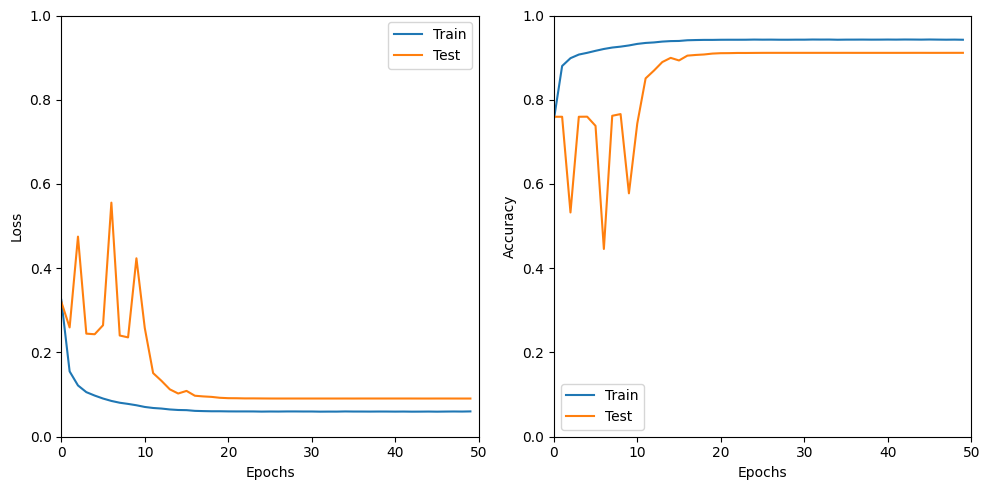

In [16]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training & validation loss values
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Test')
# axes[0].set_title('Curva de Perda')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].set_xlim([0, 50])

# Plot training & validation accuracy values
axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Test')
# axes[1].set_title('Curva de Acurácia')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].set_xlim([0, 50])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# Save the model
model.save( base_dir + '/notebooks/models/multi_unet.keras')

In [18]:
# Load the weights
model.load_weights( base_dir + '/notebooks/models/multi_unet.keras')

In [19]:
# Running Prediction
y_pred = model.predict(X_test)
# Taking the maximum value of categories
y_pred_argmax = np.argmax(y_pred, axis=3)

10/10 [==============================] - 6s 184ms/step


In [20]:
# Calculate the Overall IoU
IOU_keras = MeanIoU(num_classes=3)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# Mean IoU = 0.68806314

Mean IoU = 0.68806314


In [21]:
# How to calculate IoU for each class
values = np.array(IOU_keras.get_weights()).reshape(3, 3)
print(values)
class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2])
class1_IoU = values[1,1]/(values[1,0] + values[1,1] + values[1,2])
class2_IoU = values[2,2]/(values[2,0] + values[2,1] + values[2,2])
print('IoU for Background',class0_IoU)
print('IoU for Grain Center',class1_IoU)
print('IoU for Grain Border', class2_IoU)

# IoU for Background 0.6332784
# IoU for Grain Center 0.9484995
# IoU for Grain Border 0.8396029

[[  638389.   242979.   126702.]
 [  320362. 13693286.   423140.]
 [  157333.   413774.  2989475.]]
IoU for Background 0.6332784
IoU for Grain Center 0.9484995
IoU for Grain Border 0.8396029


1/1 [==============================] - 1s 936ms/step


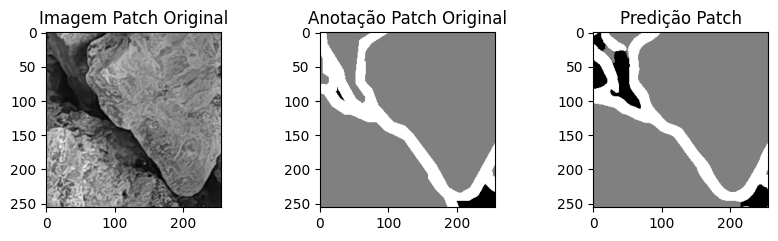

In [22]:
# Verifying Prediction Results
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
prediction_img = np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(10, 5))
plt.subplot(231)
plt.title('Imagem Patch Original')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Anotação Patch Original')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predição Patch')
plt.imshow(prediction_img, cmap='gray')
plt.show()

In [23]:
# Directory large images
base_dir = '/content/drive/MyDrive/TCC_FACENS'
large_path = base_dir + '/dataset/i_crop/conta04.tif'
mask_large_path = base_dir + '/dataset/m_crop_improved/conta04.tif'

In [24]:
# Read Large files and pathify image file
large_image = cv2.imread(large_path,0)
patches = patchify(large_image, (256,256), step=256)
large_mask = cv2.imread(mask_large_path,0)

In [25]:
# Predict a large image divided by patches
predict_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    print(i,j)

    patch = patches[i,j,:,:]
    patch_norm = np.expand_dims(normalize(np.array(patch), axis=1), 2)
    patch_input = np.expand_dims(patch_norm, 0)
    patch_pred = (model.predict(patch_input))
    patch_pred_img = np.argmax(patch_pred, axis=3)[0,:,:]
    predict_patches.append(patch_pred_img)

0 0
1/1 [==============================] - 0s 40ms/step
0 1
1/1 [==============================] - 0s 44ms/step
0 2
1/1 [==============================] - 0s 42ms/step
0 3
1/1 [==============================] - 0s 33ms/step
0 4
1/1 [==============================] - 0s 37ms/step
1 0
1/1 [==============================] - 0s 25ms/step
1 1
1/1 [==============================] - 0s 19ms/step
1 2
1/1 [==============================] - 0s 19ms/step
1 3
1/1 [==============================] - 0s 20ms/step
1 4
1/1 [==============================] - 0s 31ms/step
2 0
1/1 [==============================] - 0s 34ms/step
2 1
1/1 [==============================] - 0s 27ms/step
2 2
1/1 [==============================] - 0s 42ms/step
2 3
1/1 [==============================] - 0s 23ms/step
2 4
1/1 [==============================] - 0s 20ms/step
3 0
1/1 [==============================] - 0s 21ms/step
3 1
1/1 [==============================] - 0s 19ms/step
3 2
1/1 [==============================] - 0s 24

In [26]:
# Unpathify large image
predict_patches = np.array(predict_patches)
predict_patches_reshape = np.reshape(predict_patches, (patches.shape[0], patches.shape[1], 256, 256))
unpatched_image = unpatchify(predict_patches_reshape, large_image.shape)

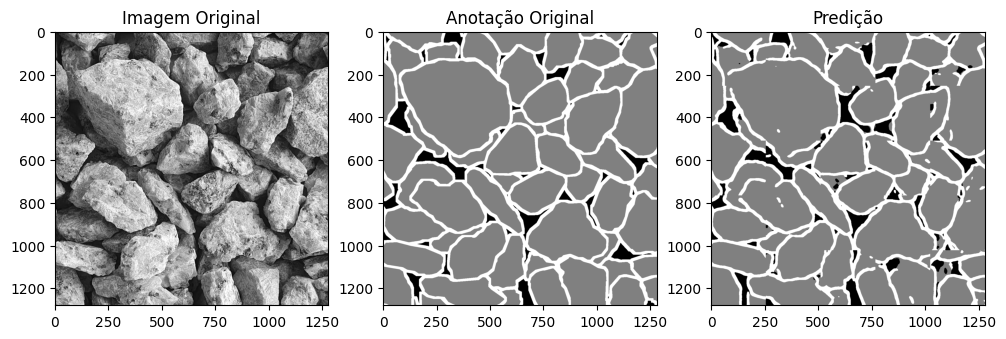

In [27]:
# Plot comparison
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Imagem Original')
plt.imshow(large_image, cmap='gray')
plt.subplot(232)
plt.title('Anotação Original')
plt.imshow(large_mask, cmap='gray')
plt.subplot(233)
plt.title('Predição')
plt.imshow(unpatched_image, cmap='gray')
plt.show()